<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/5_1_contrastive_demographic_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/5_1_contrastive_demographic_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 5.1: Contrastive Demographic Space

Phase 5 PCA on 120 "X vs. generic" demographic vectors was dominated by a shared "demographic-ness"
direction (mean cosine sim ~0.39), producing a PC1 that captures attitudinal specificity rather than
political content, and near-zero GSS validation (r~0.04).

This notebook applies two approaches to strip the shared baseline and reveal cleaner demographic axes:

**Approach 2 — Within-Category Centering:**
For each of the 25 categories, subtract the category mean vector. This removes the shared
"demographic-ness" direction within each category, leaving only within-category contrasts.

**Approach 3 — Explicit Contrastive Pairs:**
Compute all C(n,2) pairwise differences within each category: `v_A - v_B`. This directly
produces oppositional vectors that encode "A vs B" rather than "A vs generic."

**No GPU required** — PCA on small matrices is CPU-only.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.cm import get_cmap
from itertools import combinations
from scipy import stats
import os

In [2]:
# Mount Google Drive (Colab) or use local path
try:
    from google.colab import drive
    drive.mount("/content/drive")
    BASE_DIR = "/content/drive/MyDrive/belief_and_llms_v0"
except ImportError:
    BASE_DIR = "."

VECTOR_DIR = os.path.join(BASE_DIR, "vectors")
DATA_DIR = os.path.join(BASE_DIR, "data")

# Reference layer: 13 (peak delta magnitude from Phase 3 analysis)
REF_LAYER = 13

print(f"Base directory: {BASE_DIR}")
print(f"Vector directory: {VECTOR_DIR}")
print(f"Reference layer: {REF_LAYER}")

# Load vectors for the reference layer
vectors = torch.load(
    os.path.join(VECTOR_DIR, f"gss_demographic_vectors_layer{REF_LAYER}.pt"),
    map_location="cpu",
    weights_only=True,
)

# Build sorted labels, categories, and unnormalized matrix
labels = sorted(vectors.keys())
categories = [label.split('_')[0] for label in labels]
unique_cats = sorted(set(categories))

# Reconstruct raw (unnormalized) vectors: direction * magnitude
X = np.array([
    (vectors[lab]['vector'] * vectors[lab]['magnitude']).numpy()
    for lab in labels
])
magnitudes = np.array([vectors[lab]['magnitude'] for lab in labels])

print(f"\nLoaded {len(vectors)} demographic vectors from layer {REF_LAYER}")
print(f"Vector dimension: {X.shape[1]}")
print(f"Matrix shape: {X.shape}")
print(f"Categories ({len(unique_cats)}): {unique_cats}")

# Color palette for 25 categories (tab20 + tab20b)
n_cats = len(unique_cats)
tab20 = [get_cmap('tab20')(i / 20) for i in range(20)]
tab20b = [get_cmap('tab20b')(i / 20) for i in range(20)]
all_colors = tab20 + tab20b[:n_cats - 20] if n_cats > 20 else tab20[:n_cats]
cat_to_color = {cat: all_colors[i] for i, cat in enumerate(unique_cats)}

Mounted at /content/drive
Base directory: /content/drive/MyDrive/belief_and_llms_v0
Vector directory: /content/drive/MyDrive/belief_and_llms_v0/vectors
Reference layer: 13

Loaded 120 demographic vectors from layer 13
Vector dimension: 4096
Matrix shape: (120, 4096)
Categories (25): ['Age', 'Children', 'Class', 'Degree', 'FamilyIncome', 'Generation', 'God', 'Happy', 'Health', 'ImmigGen', 'Industry', 'Life', 'Marital', 'Occupation', 'OwnGun', 'PartyID', 'PolViews', 'Race', 'Region', 'Region16', 'Religion', 'SatFin', 'SatJob', 'Sex', 'Urbanity']


/tmp/ipython-input-1904831310.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = [get_cmap('tab20')(i / 20) for i in range(20)]
/tmp/ipython-input-1904831310.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20b = [get_cmap('tab20b')(i / 20) for i in range(20)]


## Approach 2: Within-Category Centering

For each of the 25 categories, compute the mean vector of its members and subtract it.
This removes the shared "X vs generic" direction within each category, isolating
within-category contrasts.

In [3]:
# Within-category centering
X_centered = np.copy(X)
cat_means = {}

for cat in unique_cats:
    mask = [c == cat for c in categories]
    indices = [i for i, m in enumerate(mask) if m]
    cat_mean = X[indices].mean(axis=0)
    cat_means[cat] = cat_mean
    X_centered[indices] -= cat_mean

# Verify centering: per-category means should be zero vectors
print("Verification: per-category mean norms after centering")
print("=" * 50)
for cat in unique_cats:
    mask = [c == cat for c in categories]
    indices = [i for i, m in enumerate(mask) if m]
    mean_norm = np.linalg.norm(X_centered[indices].mean(axis=0))
    n_members = len(indices)
    print(f"  {cat:15s}: mean_norm = {mean_norm:.2e}, n_members = {n_members}")

print(f"\nCentered matrix shape: {X_centered.shape}")
print(f"Original matrix norm: {np.linalg.norm(X, 'fro'):.2f}")
print(f"Centered matrix norm: {np.linalg.norm(X_centered, 'fro'):.2f}")

Verification: per-category mean norms after centering
  Age            : mean_norm = 2.44e-04, n_members = 4
  Children       : mean_norm = 2.44e-04, n_members = 3
  Class          : mean_norm = 2.44e-04, n_members = 4
  Degree         : mean_norm = 2.44e-04, n_members = 5
  FamilyIncome   : mean_norm = 3.45e-04, n_members = 3
  Generation     : mean_norm = 2.44e-04, n_members = 5
  God            : mean_norm = 3.45e-04, n_members = 6
  Happy          : mean_norm = 2.44e-04, n_members = 3
  Health         : mean_norm = 2.44e-04, n_members = 4
  ImmigGen       : mean_norm = 2.44e-04, n_members = 3
  Industry       : mean_norm = 2.44e-04, n_members = 14
  Life           : mean_norm = 3.45e-04, n_members = 3
  Marital        : mean_norm = 2.44e-04, n_members = 5
  Occupation     : mean_norm = 2.44e-04, n_members = 10
  OwnGun         : mean_norm = 4.23e-04, n_members = 2
  PartyID        : mean_norm = 2.44e-04, n_members = 8
  PolViews       : mean_norm = 4.23e-04, n_members = 7
  Race   

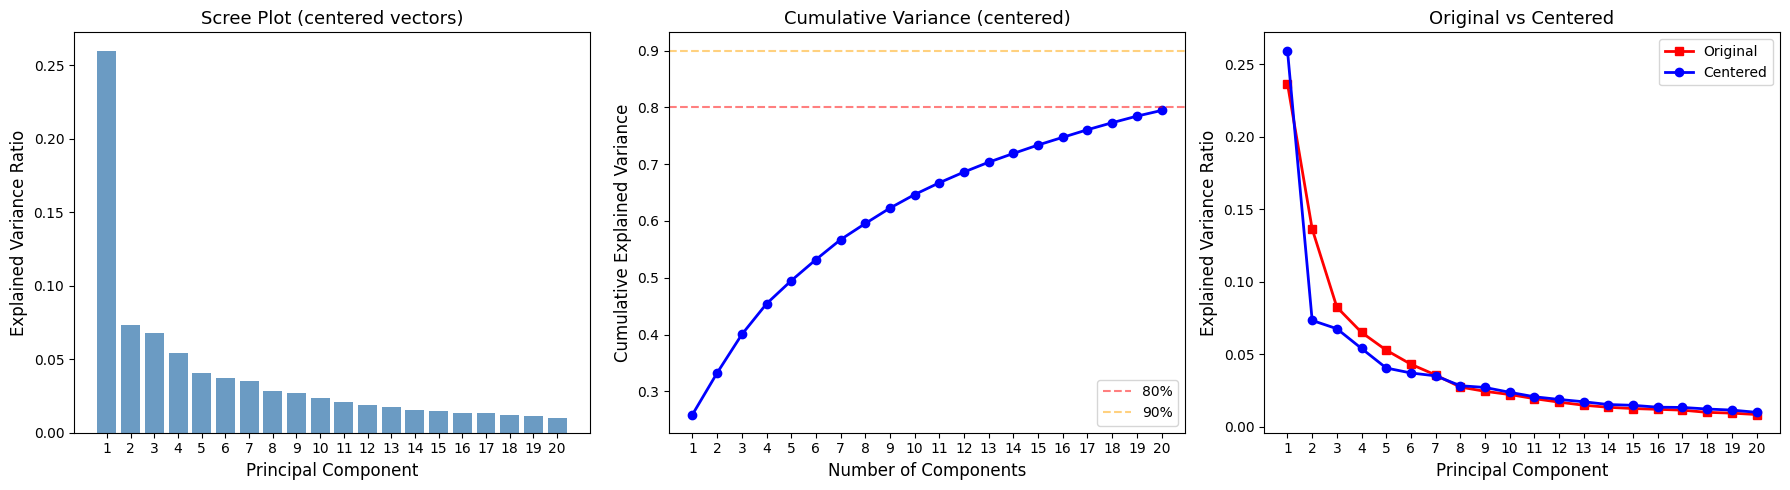


Top 10 PCs explained variance comparison:
  PC    Original    Centered        Diff
----------------------------------------
PC 1      0.2365      0.2594     +0.0229
PC 2      0.1364      0.0733     -0.0631
PC 3      0.0825      0.0676     -0.0149
PC 4      0.0651      0.0540     -0.0111
PC 5      0.0528      0.0406     -0.0123
PC 6      0.0432      0.0371     -0.0060
PC 7      0.0358      0.0352     -0.0006
PC 8      0.0274      0.0284     +0.0009
PC 9      0.0245      0.0272     +0.0027
PC10      0.0223      0.0238     +0.0015


In [4]:
# PCA on centered matrix
n_components = min(30, len(labels))

# Original PCA (for comparison)
pca_orig = PCA(n_components=n_components)
X_pca_orig = pca_orig.fit_transform(X)

# Centered PCA
pca_centered = PCA(n_components=n_components)
X_pca_centered = pca_centered.fit_transform(X_centered)

# Scree plot comparison: original vs centered
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scree plot (centered)
axes[0].bar(range(1, 21), pca_centered.explained_variance_ratio_[:20], color='steelblue', alpha=0.8)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot (centered vectors)', fontsize=13)
axes[0].set_xticks(range(1, 21))

# Cumulative (centered)
cum_var_c = np.cumsum(pca_centered.explained_variance_ratio_[:20])
axes[1].plot(range(1, 21), cum_var_c, 'bo-', linewidth=2, markersize=6)
axes[1].axhline(0.8, color='red', linestyle='--', alpha=0.5, label='80%')
axes[1].axhline(0.9, color='orange', linestyle='--', alpha=0.5, label='90%')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance (centered)', fontsize=13)
axes[1].legend()
axes[1].set_xticks(range(1, 21))

# Comparison: original vs centered
axes[2].plot(range(1, 21), pca_orig.explained_variance_ratio_[:20], 'rs-', label='Original', linewidth=2)
axes[2].plot(range(1, 21), pca_centered.explained_variance_ratio_[:20], 'bo-', label='Centered', linewidth=2)
axes[2].set_xlabel('Principal Component', fontsize=12)
axes[2].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[2].set_title('Original vs Centered', fontsize=13)
axes[2].legend()
axes[2].set_xticks(range(1, 21))

plt.tight_layout()
plt.show()

print(f"\nTop 10 PCs explained variance comparison:")
print(f"{'PC':>4s}  {'Original':>10s}  {'Centered':>10s}  {'Diff':>10s}")
print("-" * 40)
for i in range(10):
    orig_v = pca_orig.explained_variance_ratio_[i]
    cent_v = pca_centered.explained_variance_ratio_[i]
    print(f"PC{i+1:>2d}  {orig_v:10.4f}  {cent_v:10.4f}  {cent_v - orig_v:+10.4f}")

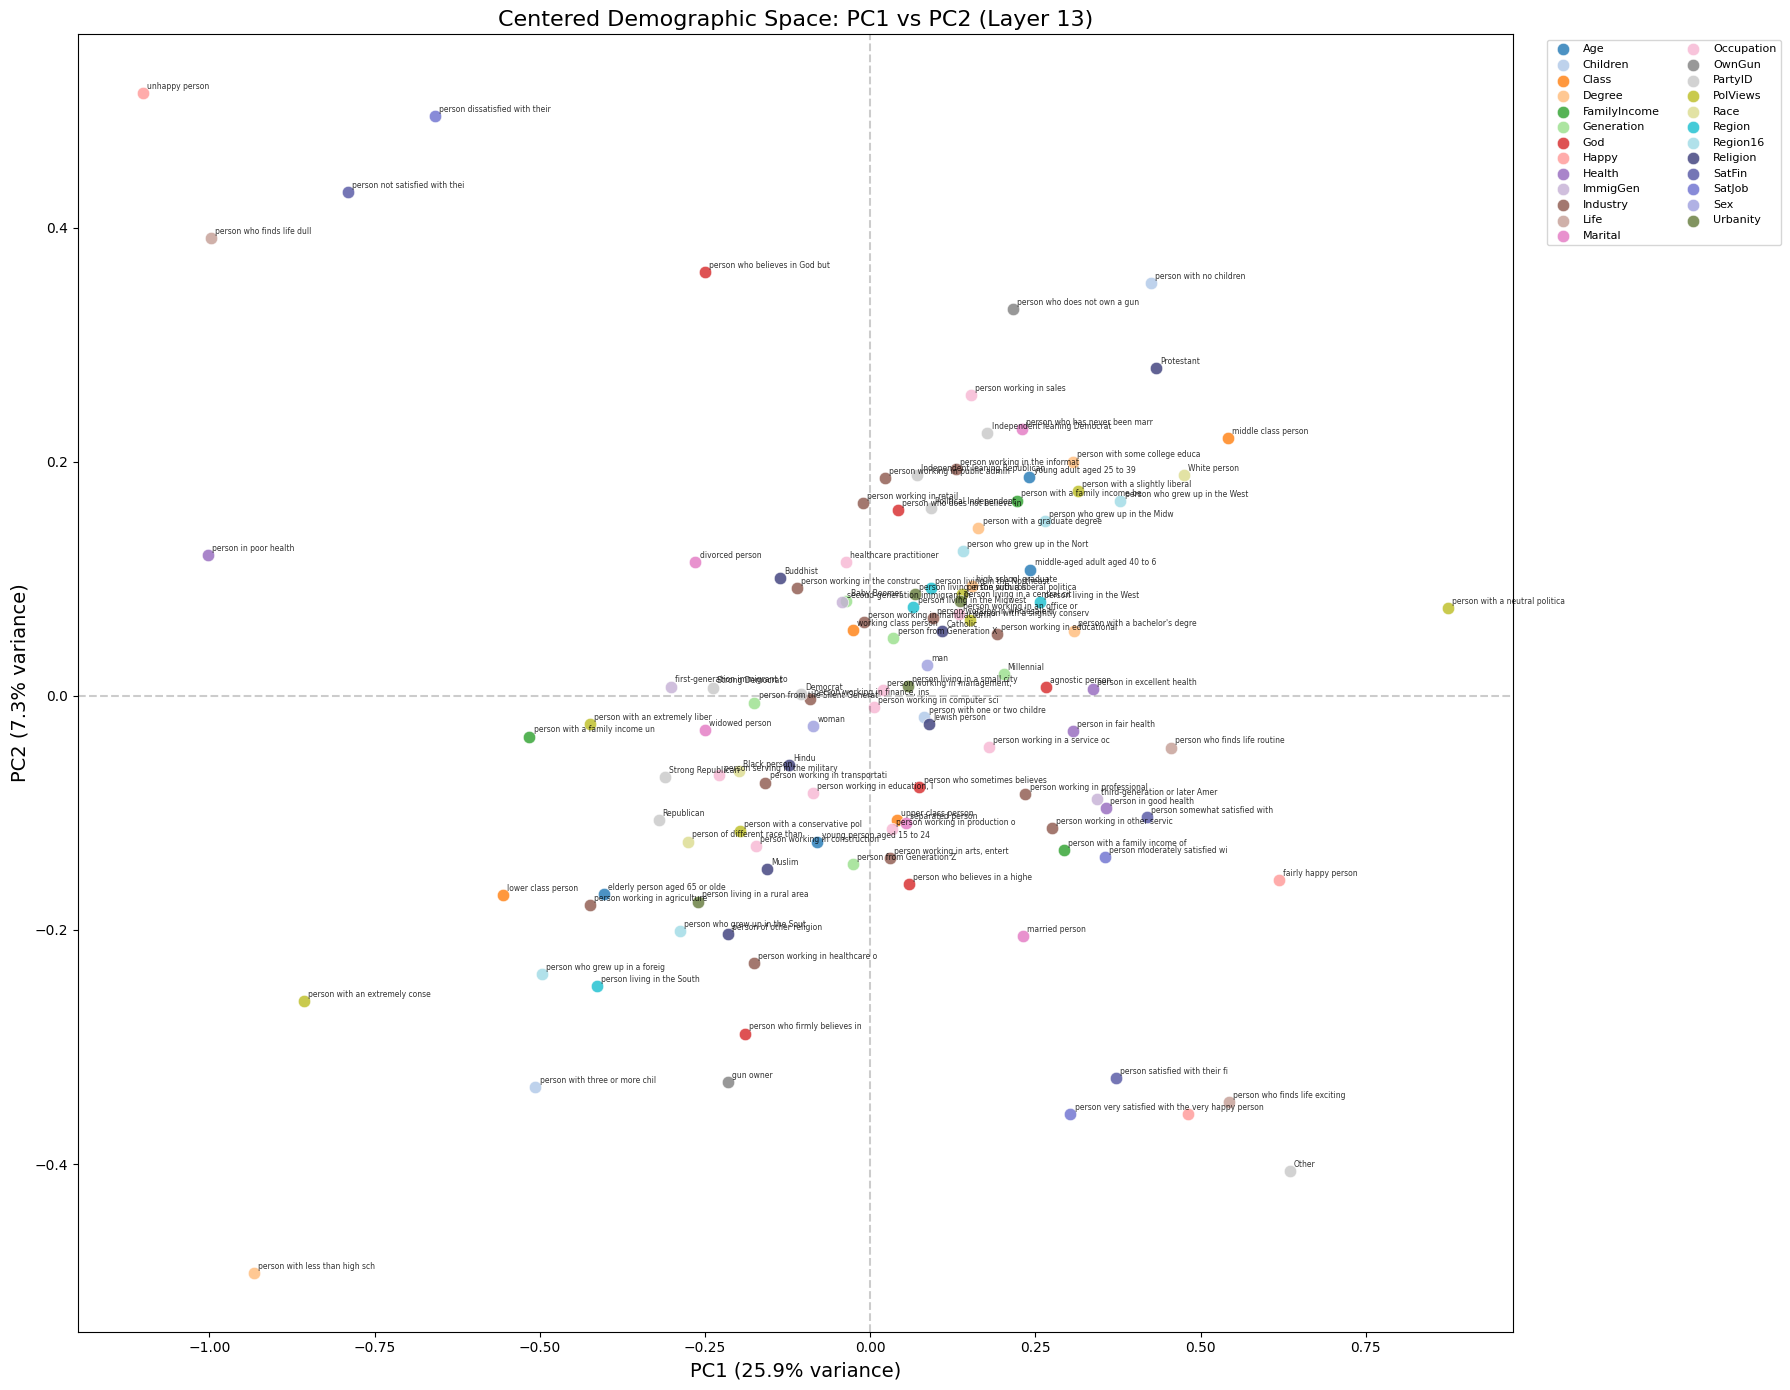

In [5]:
# Centered PCA: PC1 vs PC2 scatter
df_centered = pd.DataFrame({
    'PC1': X_pca_centered[:, 0],
    'PC2': X_pca_centered[:, 1],
    'PC3': X_pca_centered[:, 2],
    'label': labels,
    'category': categories,
    'short_label': [label.split('_', 1)[1][:30] for label in labels],
})

fig, ax = plt.subplots(figsize=(18, 14))

for cat in unique_cats:
    mask = df_centered['category'] == cat
    ax.scatter(
        df_centered.loc[mask, 'PC1'], df_centered.loc[mask, 'PC2'],
        label=cat, color=cat_to_color[cat], s=80, alpha=0.8,
        edgecolors='white', linewidth=0.5,
    )

for _, row in df_centered.iterrows():
    ax.annotate(
        row['short_label'], (row['PC1'], row['PC2']),
        fontsize=5.5, alpha=0.8,
        xytext=(3, 3), textcoords='offset points',
    )

ax.axhline(0, color='black', linestyle='--', alpha=0.2)
ax.axvline(0, color='black', linestyle='--', alpha=0.2)
ax.set_xlabel(f'PC1 ({pca_centered.explained_variance_ratio_[0]:.1%} variance)', fontsize=14)
ax.set_ylabel(f'PC2 ({pca_centered.explained_variance_ratio_[1]:.1%} variance)', fontsize=14)
ax.set_title(f'Centered Demographic Space: PC1 vs PC2 (Layer {REF_LAYER})', fontsize=16)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8, ncol=2)

plt.tight_layout()
plt.show()

In [6]:
# Centered PCA: PC Poles (top/bottom 10 on PC1-PC5)
print("CENTERED PCA — PC Poles")
for pc_idx in range(5):
    pc_name = f'PC{pc_idx + 1}'
    projections = X_pca_centered[:, pc_idx]
    sorted_idx = np.argsort(projections)

    print(f"\n{'=' * 70}")
    print(f"{pc_name} — Explained Variance: {pca_centered.explained_variance_ratio_[pc_idx]:.2%}")
    print(f"{'=' * 70}")

    print(f"\n  POSITIVE pole (top 10):")
    for i in sorted_idx[-10:][::-1]:
        print(f"    {projections[i]:+8.4f}  [{categories[i]:12s}]  {labels[i]}")

    print(f"\n  NEGATIVE pole (bottom 10):")
    for i in sorted_idx[:10]:
        print(f"    {projections[i]:+8.4f}  [{categories[i]:12s}]  {labels[i]}")

CENTERED PCA — PC Poles

PC1 — Explained Variance: 25.94%

  POSITIVE pole (top 10):
     +0.8739  [PolViews    ]  PolViews_person with a neutral political view
     +0.6348  [PartyID     ]  PartyID_Other
     +0.6190  [Happy       ]  Happy_fairly happy person
     +0.5433  [Life        ]  Life_person who finds life exciting
     +0.5414  [Class       ]  Class_middle class person
     +0.4815  [Happy       ]  Happy_very happy person
     +0.4748  [Race        ]  Race_White person
     +0.4546  [Life        ]  Life_person who finds life routine
     +0.4327  [Religion    ]  Religion_Protestant
     +0.4247  [Children    ]  Children_person with no children

  NEGATIVE pole (bottom 10):
     -1.1005  [Happy       ]  Happy_unhappy person
     -1.0025  [Health      ]  Health_person in poor health
     -0.9979  [Life        ]  Life_person who finds life dull
     -0.9330  [Degree      ]  Degree_person with less than high school education
     -0.8570  [PolViews    ]  PolViews_person with an 

## Approach 3: Explicit Contrastive Pairs

For each category, compute all C(n,2) pairwise differences: `v_A - v_B`.
These contrastive vectors directly encode "A vs B" within each category,
completely removing any shared baseline.

In [7]:
# Build contrastive pair matrix
contrastive_vectors = []
contrastive_labels = []
contrastive_categories = []

label_to_idx = {lab: i for i, lab in enumerate(labels)}

for cat in unique_cats:
    # Get sorted members of this category
    members = sorted([lab for lab in labels if lab.split('_')[0] == cat])

    # All ordered pairs (combinations)
    for a, b in combinations(members, 2):
        idx_a = label_to_idx[a]
        idx_b = label_to_idx[b]
        v_contrast = X[idx_a] - X[idx_b]

        short_a = a.split('_', 1)[1][:20]
        short_b = b.split('_', 1)[1][:20]
        pair_label = f"{cat}: {short_a} vs {short_b}"

        contrastive_vectors.append(v_contrast)
        contrastive_labels.append(pair_label)
        contrastive_categories.append(cat)

X_contrastive = np.array(contrastive_vectors)

print(f"Contrastive matrix shape: {X_contrastive.shape}")
print(f"Total contrastive pairs: {len(contrastive_labels)}")
print(f"\nPairs per category:")
for cat in unique_cats:
    n_pairs = sum(1 for c in contrastive_categories if c == cat)
    n_members = sum(1 for c in categories if c == cat)
    print(f"  {cat:15s}: {n_members} members -> C({n_members},2) = {n_pairs} pairs")

Contrastive matrix shape: (317, 4096)
Total contrastive pairs: 317

Pairs per category:
  Age            : 4 members -> C(4,2) = 6 pairs
  Children       : 3 members -> C(3,2) = 3 pairs
  Class          : 4 members -> C(4,2) = 6 pairs
  Degree         : 5 members -> C(5,2) = 10 pairs
  FamilyIncome   : 3 members -> C(3,2) = 3 pairs
  Generation     : 5 members -> C(5,2) = 10 pairs
  God            : 6 members -> C(6,2) = 15 pairs
  Happy          : 3 members -> C(3,2) = 3 pairs
  Health         : 4 members -> C(4,2) = 6 pairs
  ImmigGen       : 3 members -> C(3,2) = 3 pairs
  Industry       : 14 members -> C(14,2) = 91 pairs
  Life           : 3 members -> C(3,2) = 3 pairs
  Marital        : 5 members -> C(5,2) = 10 pairs
  Occupation     : 10 members -> C(10,2) = 45 pairs
  OwnGun         : 2 members -> C(2,2) = 1 pairs
  PartyID        : 8 members -> C(8,2) = 28 pairs
  PolViews       : 7 members -> C(7,2) = 21 pairs
  Race           : 3 members -> C(3,2) = 3 pairs
  Region         :

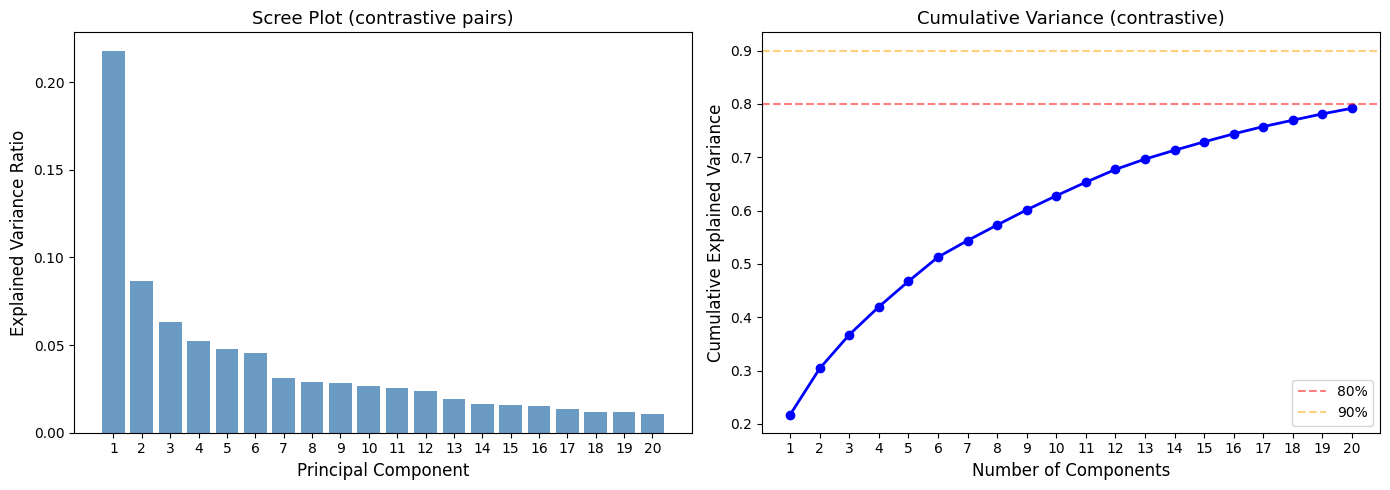


Top 10 PCs explained variance (contrastive):
  PC1: 0.2175 (cumulative: 0.2175)
  PC2: 0.0866 (cumulative: 0.3041)
  PC3: 0.0633 (cumulative: 0.3673)
  PC4: 0.0522 (cumulative: 0.4195)
  PC5: 0.0478 (cumulative: 0.4674)
  PC6: 0.0454 (cumulative: 0.5127)
  PC7: 0.0310 (cumulative: 0.5437)
  PC8: 0.0291 (cumulative: 0.5728)
  PC9: 0.0285 (cumulative: 0.6013)
  PC10: 0.0265 (cumulative: 0.6278)


In [8]:
# PCA on contrastive matrix
n_comp_contrast = min(30, len(contrastive_labels))
pca_contrast = PCA(n_components=n_comp_contrast)
X_pca_contrast = pca_contrast.fit_transform(X_contrastive)

# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, 21), pca_contrast.explained_variance_ratio_[:20], color='steelblue', alpha=0.8)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot (contrastive pairs)', fontsize=13)
axes[0].set_xticks(range(1, 21))

cum_var_k = np.cumsum(pca_contrast.explained_variance_ratio_[:20])
axes[1].plot(range(1, 21), cum_var_k, 'bo-', linewidth=2, markersize=6)
axes[1].axhline(0.8, color='red', linestyle='--', alpha=0.5, label='80%')
axes[1].axhline(0.9, color='orange', linestyle='--', alpha=0.5, label='90%')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance (contrastive)', fontsize=13)
axes[1].legend()
axes[1].set_xticks(range(1, 21))

plt.tight_layout()
plt.show()

print(f"\nTop 10 PCs explained variance (contrastive):")
for i in range(10):
    print(f"  PC{i+1}: {pca_contrast.explained_variance_ratio_[i]:.4f} "
          f"(cumulative: {sum(pca_contrast.explained_variance_ratio_[:i+1]):.4f})")

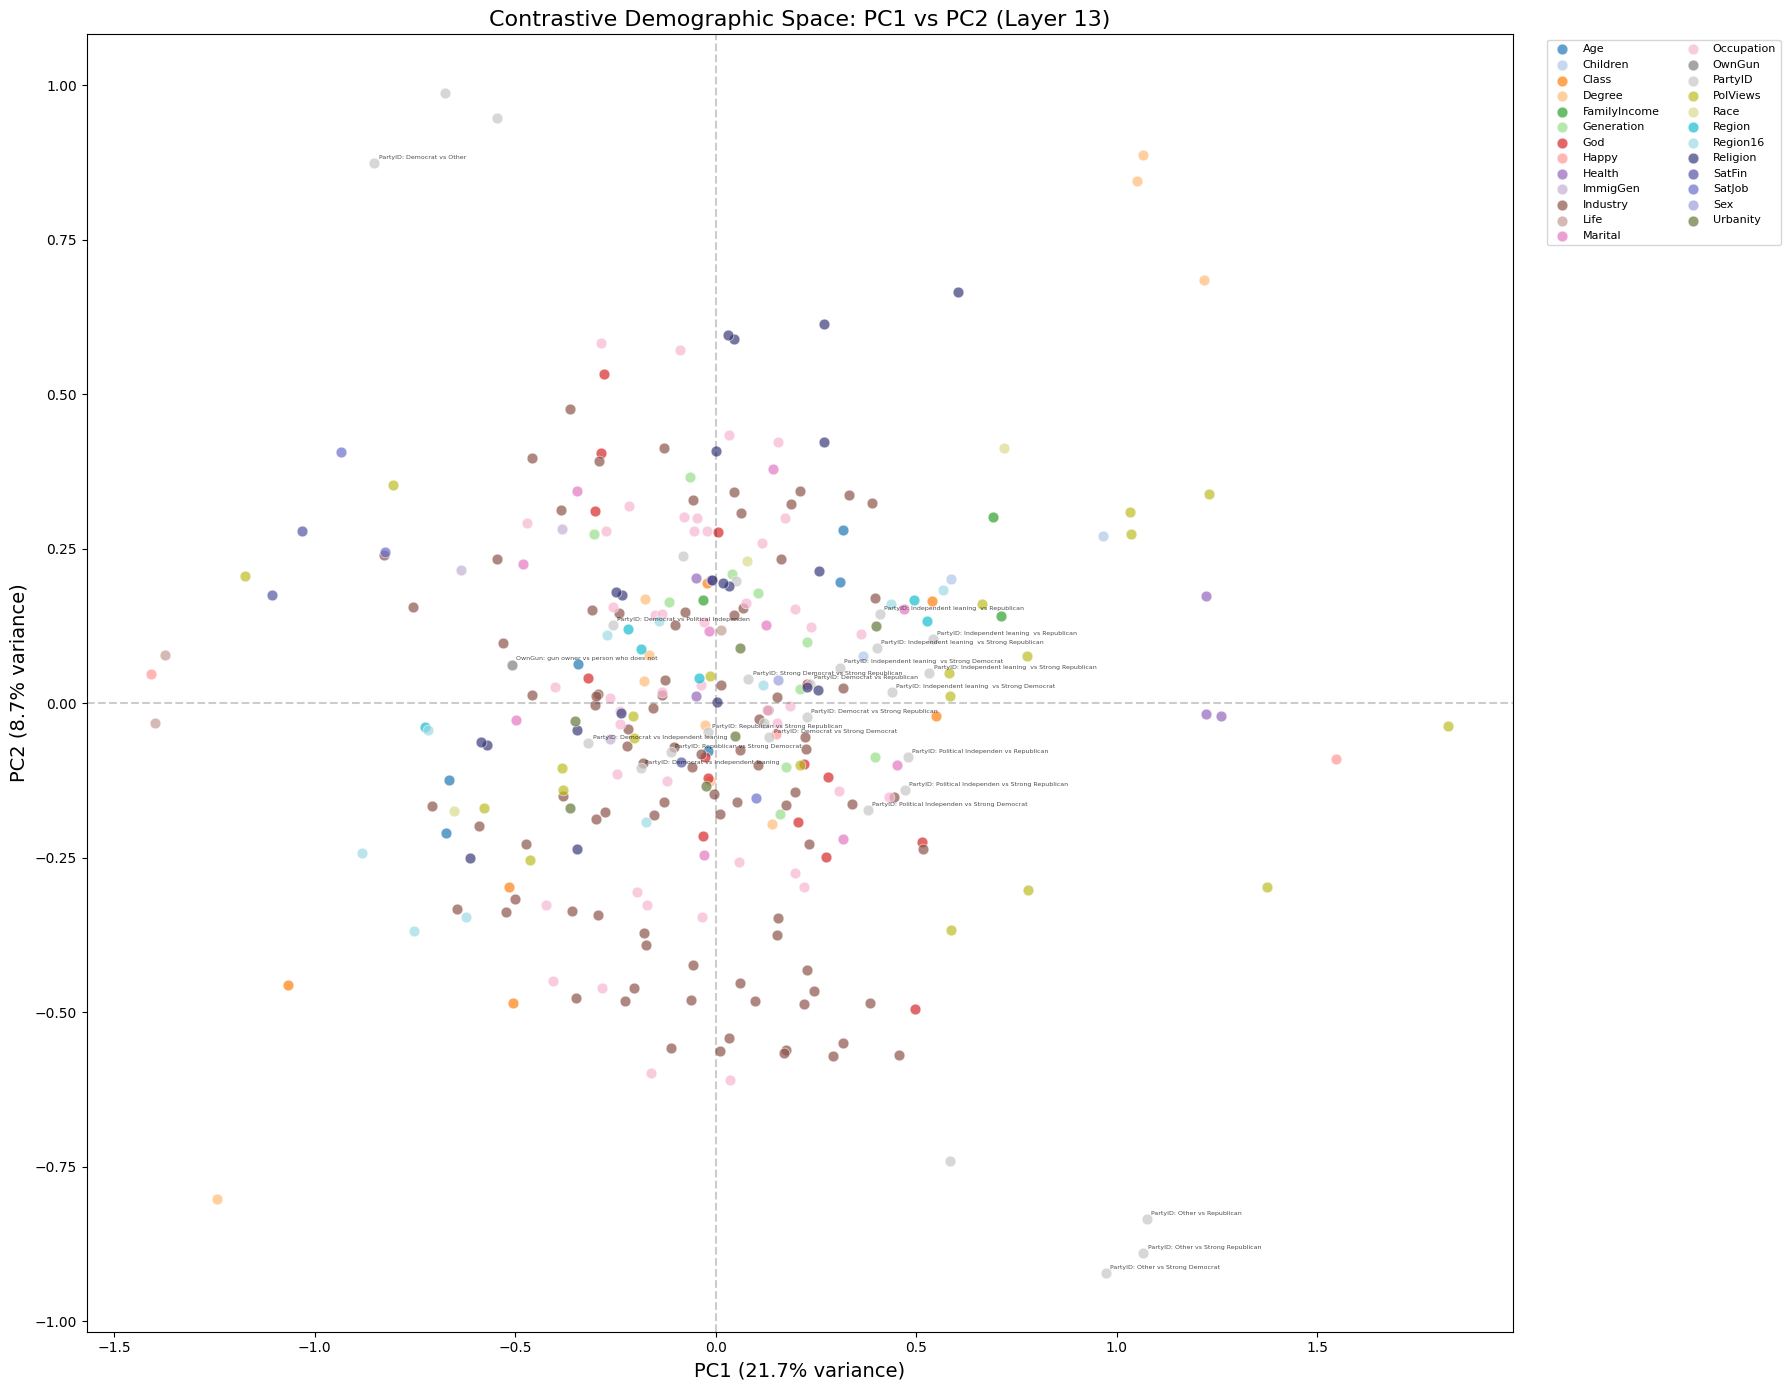

In [9]:
# Contrastive PCA: PC1 vs PC2 scatter
df_contrast = pd.DataFrame({
    'PC1': X_pca_contrast[:, 0],
    'PC2': X_pca_contrast[:, 1],
    'label': contrastive_labels,
    'category': contrastive_categories,
})

fig, ax = plt.subplots(figsize=(18, 14))

for cat in unique_cats:
    mask = df_contrast['category'] == cat
    if mask.any():
        ax.scatter(
            df_contrast.loc[mask, 'PC1'], df_contrast.loc[mask, 'PC2'],
            label=cat, color=cat_to_color[cat], s=60, alpha=0.7,
            edgecolors='white', linewidth=0.5,
        )

# Annotate politically relevant pairs
political_keywords = [
    'Democrat', 'Republican', 'Liberal', 'Conservative',
    'gun owner', 'believes in God', 'does not believe',
    'rural', 'central city',
]
for _, row in df_contrast.iterrows():
    if any(kw in row['label'] for kw in political_keywords):
        ax.annotate(
            row['label'], (row['PC1'], row['PC2']),
            fontsize=4.5, alpha=0.7,
            xytext=(3, 3), textcoords='offset points',
        )

ax.axhline(0, color='black', linestyle='--', alpha=0.2)
ax.axvline(0, color='black', linestyle='--', alpha=0.2)
ax.set_xlabel(f'PC1 ({pca_contrast.explained_variance_ratio_[0]:.1%} variance)', fontsize=14)
ax.set_ylabel(f'PC2 ({pca_contrast.explained_variance_ratio_[1]:.1%} variance)', fontsize=14)
ax.set_title(f'Contrastive Demographic Space: PC1 vs PC2 (Layer {REF_LAYER})', fontsize=16)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8, ncol=2)

plt.tight_layout()
plt.show()

In [10]:
# Contrastive PCA: PC Poles (top/bottom 10 on PC1-PC5)
print("CONTRASTIVE PCA — PC Poles")
for pc_idx in range(5):
    pc_name = f'PC{pc_idx + 1}'
    projections = X_pca_contrast[:, pc_idx]
    sorted_idx = np.argsort(projections)

    print(f"\n{'=' * 80}")
    print(f"{pc_name} — Explained Variance: {pca_contrast.explained_variance_ratio_[pc_idx]:.2%}")
    print(f"{'=' * 80}")

    print(f"\n  POSITIVE pole (top 10):")
    for i in sorted_idx[-10:][::-1]:
        print(f"    {projections[i]:+8.4f}  [{contrastive_categories[i]:12s}]  {contrastive_labels[i]}")

    print(f"\n  NEGATIVE pole (bottom 10):")
    for i in sorted_idx[:10]:
        print(f"    {projections[i]:+8.4f}  [{contrastive_categories[i]:12s}]  {contrastive_labels[i]}")

CONTRASTIVE PCA — PC Poles

PC1 — Explained Variance: 21.75%

  POSITIVE pole (top 10):
     +1.8261  [PolViews    ]  PolViews: person with a neutra vs person with an extre
     +1.5475  [Happy       ]  Happy: fairly happy person vs unhappy person
     +1.3737  [PolViews    ]  PolViews: person with a neutra vs person with an extre
     +1.2600  [Health      ]  Health: person in good healt vs person in poor healt
     +1.2292  [PolViews    ]  PolViews: person with a slight vs person with an extre
     +1.2227  [Health      ]  Health: person in excellent  vs person in poor healt
     +1.2225  [Health      ]  Health: person in fair healt vs person in poor healt
     +1.2180  [Degree      ]  Degree: person with a bachel vs person with less tha
     +1.0752  [PartyID     ]  PartyID: Other vs Republican
     +1.0666  [PartyID     ]  PartyID: Other vs Strong Republican

  NEGATIVE pole (bottom 10):
     -1.4068  [Happy       ]  Happy: unhappy person vs very happy person
     -1.3976  [Life   

## Side-by-Side Comparison: Original vs Centered vs Contrastive

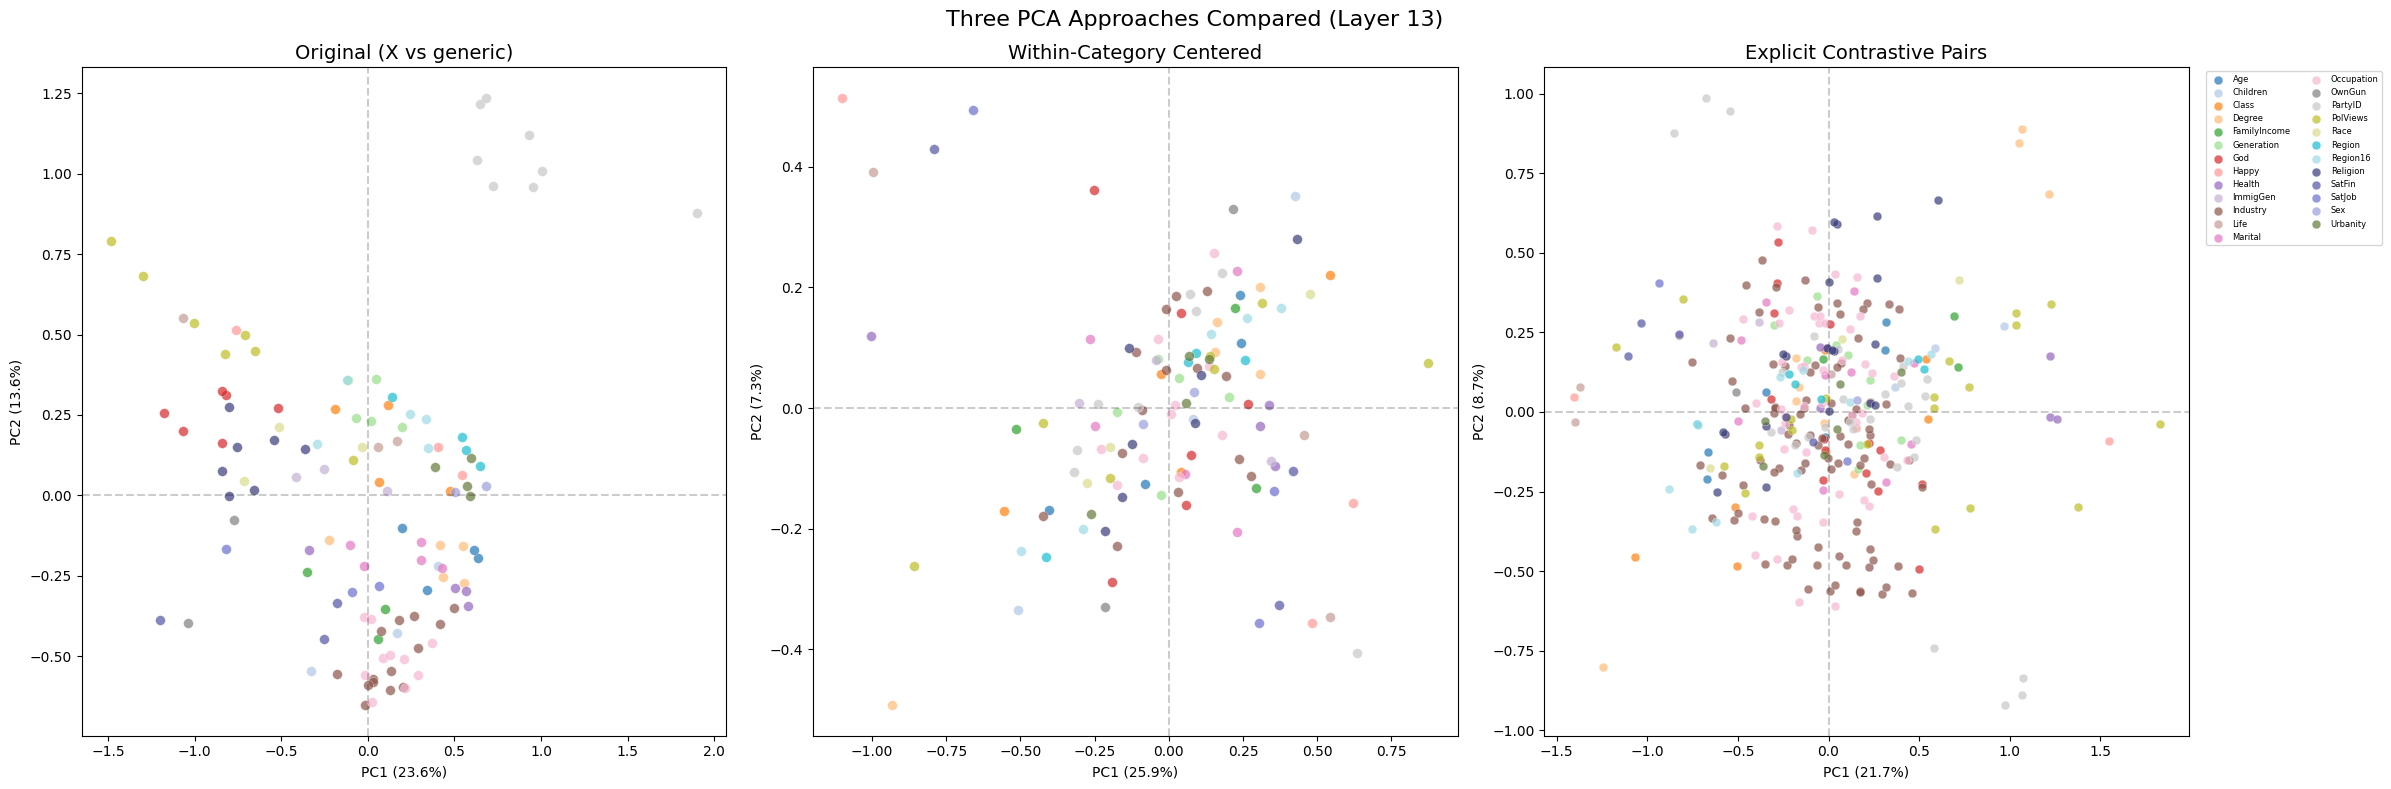


Explained Variance Comparison:
  PC    Original    Centered   Contrastive
------------------------------------------
PC 1      0.2365      0.2594        0.2175
PC 2      0.1364      0.0733        0.0866
PC 3      0.0825      0.0676        0.0633
PC 4      0.0651      0.0540        0.0522
PC 5      0.0528      0.0406        0.0478
PC 6      0.0432      0.0371        0.0454
PC 7      0.0358      0.0352        0.0310
PC 8      0.0274      0.0284        0.0291
PC 9      0.0245      0.0272        0.0285
PC10      0.0223      0.0238        0.0265


In [11]:
# Three-panel figure: Original, Centered, Contrastive — all PC1 vs PC2
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Panel 1: Original PCA
ax = axes[0]
for cat in unique_cats:
    mask = [c == cat for c in categories]
    indices = [i for i, m in enumerate(mask) if m]
    ax.scatter(
        X_pca_orig[indices, 0], X_pca_orig[indices, 1],
        label=cat, color=cat_to_color[cat], s=50, alpha=0.7,
        edgecolors='white', linewidth=0.3,
    )
ax.axhline(0, color='black', linestyle='--', alpha=0.2)
ax.axvline(0, color='black', linestyle='--', alpha=0.2)
ax.set_xlabel(f"PC1 ({pca_orig.explained_variance_ratio_[0]:.1%})")
ax.set_ylabel(f"PC2 ({pca_orig.explained_variance_ratio_[1]:.1%})")
ax.set_title('Original (X vs generic)', fontsize=14)

# Panel 2: Centered PCA
ax = axes[1]
for cat in unique_cats:
    mask = [c == cat for c in categories]
    indices = [i for i, m in enumerate(mask) if m]
    ax.scatter(
        X_pca_centered[indices, 0], X_pca_centered[indices, 1],
        label=cat, color=cat_to_color[cat], s=50, alpha=0.7,
        edgecolors='white', linewidth=0.3,
    )
ax.axhline(0, color='black', linestyle='--', alpha=0.2)
ax.axvline(0, color='black', linestyle='--', alpha=0.2)
ax.set_xlabel(f"PC1 ({pca_centered.explained_variance_ratio_[0]:.1%})")
ax.set_ylabel(f"PC2 ({pca_centered.explained_variance_ratio_[1]:.1%})")
ax.set_title('Within-Category Centered', fontsize=14)

# Panel 3: Contrastive PCA
ax = axes[2]
for cat in unique_cats:
    mask = [c == cat for c in contrastive_categories]
    if any(mask):
        indices = [i for i, m in enumerate(mask) if m]
        ax.scatter(
            X_pca_contrast[indices, 0], X_pca_contrast[indices, 1],
            label=cat, color=cat_to_color[cat], s=40, alpha=0.7,
            edgecolors='white', linewidth=0.3,
        )
ax.axhline(0, color='black', linestyle='--', alpha=0.2)
ax.axvline(0, color='black', linestyle='--', alpha=0.2)
ax.set_xlabel(f"PC1 ({pca_contrast.explained_variance_ratio_[0]:.1%})")
ax.set_ylabel(f"PC2 ({pca_contrast.explained_variance_ratio_[1]:.1%})")
ax.set_title('Explicit Contrastive Pairs', fontsize=14)

axes[-1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=6, ncol=2)
plt.suptitle(f'Three PCA Approaches Compared (Layer {REF_LAYER})', fontsize=16)
plt.tight_layout()
plt.show()

# Print comparison table
print(f"\nExplained Variance Comparison:")
print(f"{'PC':>4s}  {'Original':>10s}  {'Centered':>10s}  {'Contrastive':>12s}")
print("-" * 42)
for i in range(10):
    print(f"PC{i+1:>2d}  {pca_orig.explained_variance_ratio_[i]:10.4f}  "
          f"{pca_centered.explained_variance_ratio_[i]:10.4f}  "
          f"{pca_contrast.explained_variance_ratio_[i]:12.4f}")

## Liberal-Conservative Hypothesis Test

For each PCA space, compute mean PC1 for liberal vs conservative clusters
and culture-war demographics. Check which approach best separates them.

In [12]:
# Define clusters
liberal_labels = [
    'PartyID_Strong Democrat',
    'PolViews_person with a liberal political view',
    'PolViews_person with an extremely liberal political view',
]
conservative_labels = [
    'PartyID_Strong Republican',
    'PolViews_person with a conservative political view',
    'PolViews_person with an extremely conservative political view',
]
culture_war = {
    'Gun owner vs Non-owner': ('OwnGun_gun owner', 'OwnGun_person who does not own a gun'),
    'Firm believer vs Non-believer': ('God_person who firmly believes in God', 'God_person who does not believe in God'),
    'Rural vs Urban': ('Urbanity_person living in a rural area', 'Urbanity_person living in a central city'),
}

def get_mean_pc1(pca_result, target_labels, all_labels):
    """Get mean PC1 projection for a set of labels."""
    vals = []
    for lab in target_labels:
        if lab in all_labels:
            idx = all_labels.index(lab)
            vals.append(pca_result[idx, 0])
    return np.mean(vals) if vals else np.nan

# --- Original PCA ---
print("LIBERAL-CONSERVATIVE SEPARATION ON PC1")
print("=" * 70)

approaches = [
    ('Original', X_pca_orig, labels),
    ('Centered', X_pca_centered, labels),
]

results = []
for name, pca_result, lab_list in approaches:
    lib_mean = get_mean_pc1(pca_result, liberal_labels, lab_list)
    con_mean = get_mean_pc1(pca_result, conservative_labels, lab_list)
    separation = abs(lib_mean - con_mean)
    results.append({'Approach': name, 'Liberal mean PC1': lib_mean,
                    'Conservative mean PC1': con_mean, 'Separation': separation})

    print(f"\n{name}:")
    print(f"  Liberal cluster mean PC1:      {lib_mean:+.4f}")
    print(f"  Conservative cluster mean PC1: {con_mean:+.4f}")
    print(f"  Separation (|diff|):           {separation:.4f}")

    print(f"\n  Culture war demographics on PC1:")
    for desc, (lab_a, lab_b) in culture_war.items():
        if lab_a in lab_list and lab_b in lab_list:
            idx_a = lab_list.index(lab_a)
            idx_b = lab_list.index(lab_b)
            val_a = pca_result[idx_a, 0]
            val_b = pca_result[idx_b, 0]
            print(f"    {desc:35s}: {val_a:+.4f} vs {val_b:+.4f}  (diff={val_a - val_b:+.4f})")

print(f"\n{'=' * 70}")
print("\nSummary Table:")
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

LIBERAL-CONSERVATIVE SEPARATION ON PC1

Original:
  Liberal cluster mean PC1:      -0.4989
  Conservative cluster mean PC1: -0.6020
  Separation (|diff|):           0.1031

  Culture war demographics on PC1:
    Gun owner vs Non-owner             : -1.0378 vs -0.7731  (diff=-0.2647)
    Firm believer vs Non-believer      : -1.0700 vs -0.8423  (diff=-0.2277)
    Rural vs Urban                     : +0.3881 vs +0.5885  (diff=-0.2003)

Centered:
  Liberal cluster mean PC1:      -0.1745
  Conservative cluster mean PC1: -0.4548
  Separation (|diff|):           0.2803

  Culture war demographics on PC1:
    Gun owner vs Non-owner             : -0.2159 vs +0.2159  (diff=-0.4317)
    Firm believer vs Non-believer      : -0.1900 vs +0.0425  (diff=-0.2325)
    Rural vs Urban                     : -0.2611 vs +0.1362  (diff=-0.3973)


Summary Table:
Approach  Liberal mean PC1  Conservative mean PC1  Separation
Original         -0.498869              -0.602009    0.103139
Centered         -0.174463

## GSS Phi-Coefficient Validation

Compare cosine similarity between centered vectors with GSS phi-coefficients.
If centering removes shared baseline noise, the correlation should improve from the
Phase 5 baseline (r~0.04).

In [13]:
# GSS-to-vector mapping (same as Phase 5)
GSS_TO_VECTOR = {
    # Race
    'race_Black': 'Race_Black person',
    'race_White': 'Race_White person',
    'race_Other': 'Race_person of different race than Black or White',
    # PartyID
    'partyid_Strong democrat': 'PartyID_Strong Democrat',
    'partyid_Strong republican': 'PartyID_Strong Republican',
    'partyid_Not very strong democrat': 'PartyID_Democrat',
    'partyid_Not very strong republican': 'PartyID_Republican',
    'partyid_Independent, close to democrat': 'PartyID_Independent leaning Democrat',
    'partyid_Independent, close to republican': 'PartyID_Independent leaning Republican',
    'partyid_Independent (neither, no response)': 'PartyID_Political Independent',
    'partyid_Other party': 'PartyID_Other',
    # Sex
    'sex_MALE': 'Sex_man',
    'sex_FEMALE': 'Sex_woman',
    # Degree
    'degree_Less than high school': 'Degree_person with less than high school education',
    'degree_High school': 'Degree_high school graduate',
    'degree_Associate/junior college': 'Degree_person with some college education',
    "degree_Bachelor's": "Degree_person with a bachelor's degree",
    'degree_Graduate': 'Degree_person with a graduate degree',
    # Religion
    'relig_Catholic': 'Religion_Catholic',
    'relig_Protestant': 'Religion_Protestant',
    'relig_Buddhism': 'Religion_Buddhist',
    'relig_Jewish': 'Religion_Jewish person',
    'relig_Muslim/Islam': 'Religion_Muslim',
    'relig_Hinduism': 'Religion_Hindu',
    'relig_Other': 'Religion_person of other religion',
    # PolViews
    'polviews_Extremely liberal': 'PolViews_person with an extremely liberal political view',
    'polviews_Liberal': 'PolViews_person with a liberal political view',
    'polviews_Slightly liberal': 'PolViews_person with a slightly liberal political view',
    'polviews_Moderate, middle of the road': 'PolViews_person with a neutral political view',
    'polviews_Slightly conservative': 'PolViews_person with a slightly conservative political view',
    'polviews_Conservative': 'PolViews_person with a conservative political view',
    'polviews_Extremely conservative': 'PolViews_person with an extremely conservative political view',
    # Generation
    'generation_Generation Z': 'Generation_person from Generation Z',
    'generation_Millennial': 'Generation_Millennial',
    'generation_Generation X': 'Generation_person from Generation X',
    'generation_Baby Boomer': 'Generation_Baby Boomer',
    'generation_Silent Generation': 'Generation_person from the Silent Generation',
    # Marital
    'marital_Married': 'Marital_married person',
    'marital_Divorced': 'Marital_divorced person',
    'marital_Widowed': 'Marital_widowed person',
    'marital_Separated': 'Marital_separated person',
    'marital_Never married': 'Marital_person who has never been married',
    # Age
    'age_group_Youth (15-24)': 'Age_young person aged 15 to 24',
    'age_group_Young Adult (25-39)': 'Age_young adult aged 25 to 39',
    'age_group_Middle Adult (40-64)': 'Age_middle-aged adult aged 40 to 64',
    'age_group_Elderly (65+)': 'Age_elderly person aged 65 or older',
    # Children
    'childs_group_No children': 'Children_person with no children',
    'childs_group_1-2 children': 'Children_person with one or two children',
    'childs_group_3 or more children': 'Children_person with three or more children',
    # Immigration
    'immig_gen_1st generation immigrant': 'ImmigGen_first-generation immigrant to the United States',
    'immig_gen_2nd generation immigrant': 'ImmigGen_second-generation immigrant in the United States',
    'immig_gen_3rd+ generation American': 'ImmigGen_third-generation or later American',
    # Region (grew up)
    'reg16_Northeast': 'Region16_person who grew up in the Northeast',
    'reg16_Midwest': 'Region16_person who grew up in the Midwest',
    'reg16_South': 'Region16_person who grew up in the South',
    'reg16_West': 'Region16_person who grew up in the West',
    'reg16_Foreign': 'Region16_person who grew up in a foreign country',
    # Family income
    'income_group_Income under $10k': 'FamilyIncome_person with a family income under $10,000',
    'income_group_Income $10k-$25k': 'FamilyIncome_person with a family income between $10,000 and $25,000',
    'income_group_Income $25k or more': 'FamilyIncome_person with a family income of $25,000 or more',
    # Region (current)
    'region_Northeast': 'Region_person living in the Northeast',
    'region_Midwest': 'Region_person living in the Midwest',
    'region_South': 'Region_person living in the South',
    'region_West': 'Region_person living in the West',
    # Urbanity
    'srcbelt_group_Central city': 'Urbanity_person living in a central city',
    'srcbelt_group_Suburban': 'Urbanity_person living in the suburbs',
    'srcbelt_group_Other urban': 'Urbanity_person living in a small city or town',
    'srcbelt_group_Rural': 'Urbanity_person living in a rural area',
    # Happiness
    'happy_Very happy': 'Happy_very happy person',
    'happy_Pretty happy': 'Happy_fairly happy person',
    'happy_Not too happy': 'Happy_unhappy person',
    # Health
    'health_Excellent': 'Health_person in excellent health',
    'health_Good': 'Health_person in good health',
    'health_Fair': 'Health_person in fair health',
    'health_Poor': 'Health_person in poor health',
    # Life excitement
    'life_Exciting': 'Life_person who finds life exciting',
    'life_Routine': 'Life_person who finds life routine',
    'life_Dull': 'Life_person who finds life dull',
    # Job satisfaction
    'satjob_group_Very satisfied': 'SatJob_person very satisfied with their job',
    'satjob_group_Moderately satisfied': 'SatJob_person moderately satisfied with their job',
    'satjob_group_Dissatisfied': 'SatJob_person dissatisfied with their job',
    # Social class
    'class__Lower class': 'Class_lower class person',
    'class__Working class': 'Class_working class person',
    'class__Middle class': 'Class_middle class person',
    'class__Upper class': 'Class_upper class person',
    # Financial satisfaction
    'satfin_Pretty well satisfied': 'SatFin_person satisfied with their financial situation',
    'satfin_More or less satisfied': 'SatFin_person somewhat satisfied with their financial situation',
    'satfin_Not satisfied at all': 'SatFin_person not satisfied with their financial situation',
    # Gun ownership
    'owngun_YES': 'OwnGun_gun owner',
    'owngun_NO': 'OwnGun_person who does not own a gun',
    # Belief in God
    'god_No doubts': 'God_person who firmly believes in God',
    'god_Believe with doubts': 'God_person who believes in God but with some doubts',
    'god_Believe sometimes': 'God_person who sometimes believes in God',
    "god_Don't know, no way to find out": 'God_agnostic person',
    'god_Higher power': 'God_person who believes in a higher power but not a personal God',
    "god_Don't believe": 'God_person who does not believe in God',
    # Occupation
    'occ_group_Service': 'Occupation_person working in a service occupation',
    'occ_group_Natural Resources, Construction, and Maintenance': 'Occupation_person working in construction, maintenance, or natural resources',
    'occ_group_Office and Administrative Support': 'Occupation_person working in an office or administrative support role',
    'occ_group_Management, Business, and Financial': 'Occupation_person working in management, business, or finance',
    'occ_group_Education, Legal, Community Service, Arts, and Media': 'Occupation_person working in education, law, community service, arts, or media',
    'occ_group_Computer, Engineering, and Science': 'Occupation_person working in computer science, engineering, or science',
    'occ_group_Military': 'Occupation_person serving in the military',
    'occ_group_Production, Transportation, and Material Moving': 'Occupation_person working in production or transportation',
    'occ_group_Sales and Related': 'Occupation_person working in sales',
    'occ_group_Healthcare Practitioners and Technical': 'Occupation_healthcare practitioner',
    # Industry
    'indus_group_Health Care and Social Assistance': 'Industry_person working in healthcare or social assistance',
    'indus_group_Wholesale Trade': 'Industry_person working in wholesale trade',
    'indus_group_Manufacturing': 'Industry_person working in manufacturing',
    'indus_group_Construction': 'Industry_person working in the construction industry',
    'indus_group_Finance and Insurance, and Real Estate': 'Industry_person working in finance, insurance, or real estate',
    'indus_group_Arts, Entertainment, Recreation, and Accommodation and Food Services': 'Industry_person working in arts, entertainment, or food services',
    'indus_group_Information': 'Industry_person working in the information industry',
    'indus_group_Educational Services': 'Industry_person working in educational services',
    'indus_group_Public Administration': 'Industry_person working in public administration',
    'indus_group_Professional, Scientific, Management, and Administrative Services': 'Industry_person working in professional or scientific services',
    'indus_group_Transportation and Warehousing, and Utilities': 'Industry_person working in transportation or utilities',
    'indus_group_Retail Trade': 'Industry_person working in retail',
    'indus_group_Other Services (Except Public Administration)': 'Industry_person working in other services',
    'indus_group_Agriculture, Forestry, Fishing and Hunting, and Mining': 'Industry_person working in agriculture or mining',
}

print(f"GSS_TO_VECTOR mapping: {len(GSS_TO_VECTOR)} entries")

GSS_TO_VECTOR mapping: 120 entries


In [14]:
# Load GSS phi-coefficient correlations
corr_df = pd.read_csv(os.path.join(DATA_DIR, "gss_correlation_pairs.csv"))
print(f"Loaded {len(corr_df)} correlation pairs")

# Compute cosine similarities for original and centered vectors
cos_sim_orig = cosine_similarity(X)
cos_sim_centered = cosine_similarity(X_centered)

# Build comparison dataframe
comparison_data = []

for _, row in corr_df.iterrows():
    var1, var2, phi = row['Var1'], row['Var2'], row['Correlation']

    vec_label1 = GSS_TO_VECTOR.get(var1)
    vec_label2 = GSS_TO_VECTOR.get(var2)

    if vec_label1 and vec_label2 and vec_label1 in label_to_idx and vec_label2 in label_to_idx:
        idx1 = label_to_idx[vec_label1]
        idx2 = label_to_idx[vec_label2]
        comparison_data.append({
            'gss_var1': var1, 'gss_var2': var2,
            'vec_label1': vec_label1, 'vec_label2': vec_label2,
            'phi_coefficient': phi,
            'cos_sim_original': cos_sim_orig[idx1, idx2],
            'cos_sim_centered': cos_sim_centered[idx1, idx2],
        })

comp_df = pd.DataFrame(comparison_data)
print(f"Matched {len(comp_df)} out of {len(corr_df)} correlation pairs")

# Compute correlations
pearson_orig = comp_df['phi_coefficient'].corr(comp_df['cos_sim_original'])
spearman_orig = comp_df['phi_coefficient'].corr(comp_df['cos_sim_original'], method='spearman')
pearson_centered = comp_df['phi_coefficient'].corr(comp_df['cos_sim_centered'])
spearman_centered = comp_df['phi_coefficient'].corr(comp_df['cos_sim_centered'], method='spearman')

print(f"\nGSS Validation Results:")
print(f"{'Approach':>15s}  {'Pearson r':>10s}  {'Spearman rho':>13s}")
print("-" * 42)
print(f"{'Original':>15s}  {pearson_orig:10.4f}  {spearman_orig:13.4f}")
print(f"{'Centered':>15s}  {pearson_centered:10.4f}  {spearman_centered:13.4f}")

Loaded 722 correlation pairs
Matched 542 out of 722 correlation pairs

GSS Validation Results:
       Approach   Pearson r   Spearman rho
------------------------------------------
       Original      0.0385         0.0462
       Centered      0.2603         0.2092


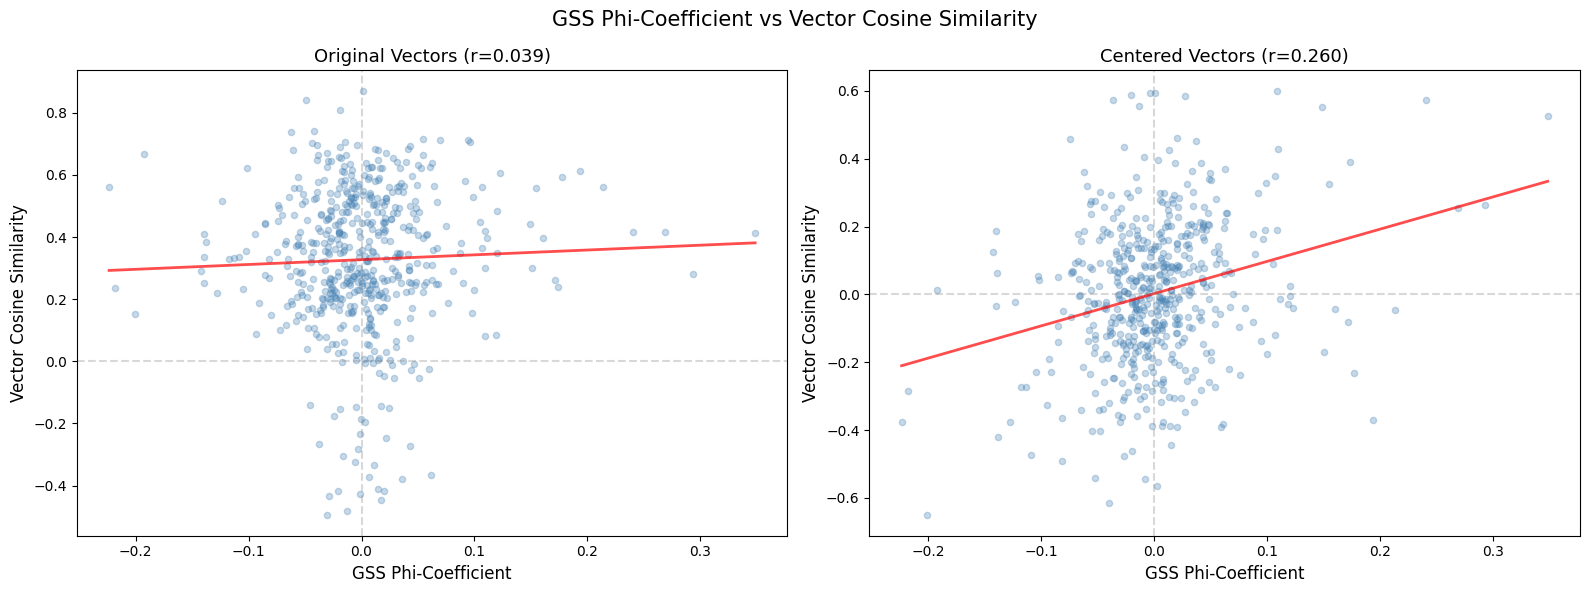


Breakdown by pair type:
                Type      N   Pearson (orig)   Pearson (cent)
------------------------------------------------------------
      Cross-category    542           0.0385           0.2603


In [15]:
# Scatter plots: phi-coefficient vs cosine similarity (original vs centered, side by side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, col, title, r_val in [
    (axes[0], 'cos_sim_original', 'Original Vectors', pearson_orig),
    (axes[1], 'cos_sim_centered', 'Centered Vectors', pearson_centered),
]:
    ax.scatter(comp_df['phi_coefficient'], comp_df[col],
              alpha=0.3, s=20, color='steelblue')

    # Fit line
    z = np.polyfit(comp_df['phi_coefficient'], comp_df[col], 1)
    p = np.poly1d(z)
    x_fit = np.linspace(comp_df['phi_coefficient'].min(), comp_df['phi_coefficient'].max(), 100)
    ax.plot(x_fit, p(x_fit), 'r-', linewidth=2, alpha=0.7)

    ax.set_xlabel('GSS Phi-Coefficient', fontsize=12)
    ax.set_ylabel('Vector Cosine Similarity', fontsize=12)
    ax.set_title(f'{title} (r={r_val:.3f})', fontsize=13)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.3)

plt.suptitle('GSS Phi-Coefficient vs Vector Cosine Similarity', fontsize=15)
plt.tight_layout()
plt.show()

# Show cross-category vs within-category breakdown
comp_df['same_category'] = [
    row['vec_label1'].split('_')[0] == row['vec_label2'].split('_')[0]
    for _, row in comp_df.iterrows()
]

print(f"\nBreakdown by pair type:")
print(f"{'Type':>20s}  {'N':>5s}  {'Pearson (orig)':>15s}  {'Pearson (cent)':>15s}")
print("-" * 60)
for same_cat, label in [(True, 'Within-category'), (False, 'Cross-category')]:
    sub = comp_df[comp_df['same_category'] == same_cat]
    if len(sub) > 2:
        r_o = sub['phi_coefficient'].corr(sub['cos_sim_original'])
        r_c = sub['phi_coefficient'].corr(sub['cos_sim_centered'])
        print(f"{label:>20s}  {len(sub):5d}  {r_o:15.4f}  {r_c:15.4f}")

## Multi-Layer Comparison (Centered PCA)

Run within-category centering + PCA across layers 5, 9, 13, 17, 20 to check
whether centering improves cross-layer consistency.

In [16]:
comparison_layers = [5, 9, 13, 17, 20]
layer_results_orig = {}
layer_results_centered = {}

for layer in comparison_layers:
    vecs = torch.load(
        os.path.join(VECTOR_DIR, f"gss_demographic_vectors_layer{layer}.pt"),
        map_location="cpu",
        weights_only=True,
    )

    layer_labels = sorted(vecs.keys())
    layer_cats = [lab.split('_')[0] for lab in layer_labels]
    layer_X = np.array([
        (vecs[lab]['vector'] * vecs[lab]['magnitude']).numpy()
        for lab in layer_labels
    ])

    # Original PCA
    pca_o = PCA(n_components=min(20, len(layer_labels)))
    X_pca_o = pca_o.fit_transform(layer_X)
    layer_results_orig[layer] = {
        'labels': layer_labels, 'categories': layer_cats,
        'X_pca': X_pca_o, 'pca': pca_o,
        'explained_variance': pca_o.explained_variance_ratio_,
    }

    # Within-category centering
    layer_X_c = np.copy(layer_X)
    layer_unique_cats = sorted(set(layer_cats))
    for cat in layer_unique_cats:
        mask = [c == cat for c in layer_cats]
        indices = [i for i, m in enumerate(mask) if m]
        cat_mean = layer_X[indices].mean(axis=0)
        layer_X_c[indices] -= cat_mean

    pca_c = PCA(n_components=min(20, len(layer_labels)))
    X_pca_c = pca_c.fit_transform(layer_X_c)
    layer_results_centered[layer] = {
        'labels': layer_labels, 'categories': layer_cats,
        'X_pca': X_pca_c, 'pca': pca_c,
        'explained_variance': pca_c.explained_variance_ratio_,
    }

    print(f"Layer {layer:2d}:  Original PC1={pca_o.explained_variance_ratio_[0]:.3f}  "
          f"Centered PC1={pca_c.explained_variance_ratio_[0]:.3f}  "
          f"Original top-3={sum(pca_o.explained_variance_ratio_[:3]):.3f}  "
          f"Centered top-3={sum(pca_c.explained_variance_ratio_[:3]):.3f}")

Layer  5:  Original PC1=0.172  Centered PC1=0.125  Original top-3=0.369  Centered top-3=0.287
Layer  9:  Original PC1=0.165  Centered PC1=0.132  Original top-3=0.396  Centered top-3=0.287
Layer 13:  Original PC1=0.236  Centered PC1=0.259  Original top-3=0.455  Centered top-3=0.400
Layer 17:  Original PC1=0.208  Centered PC1=0.230  Original top-3=0.419  Centered top-3=0.413
Layer 20:  Original PC1=0.218  Centered PC1=0.241  Original top-3=0.419  Centered top-3=0.434


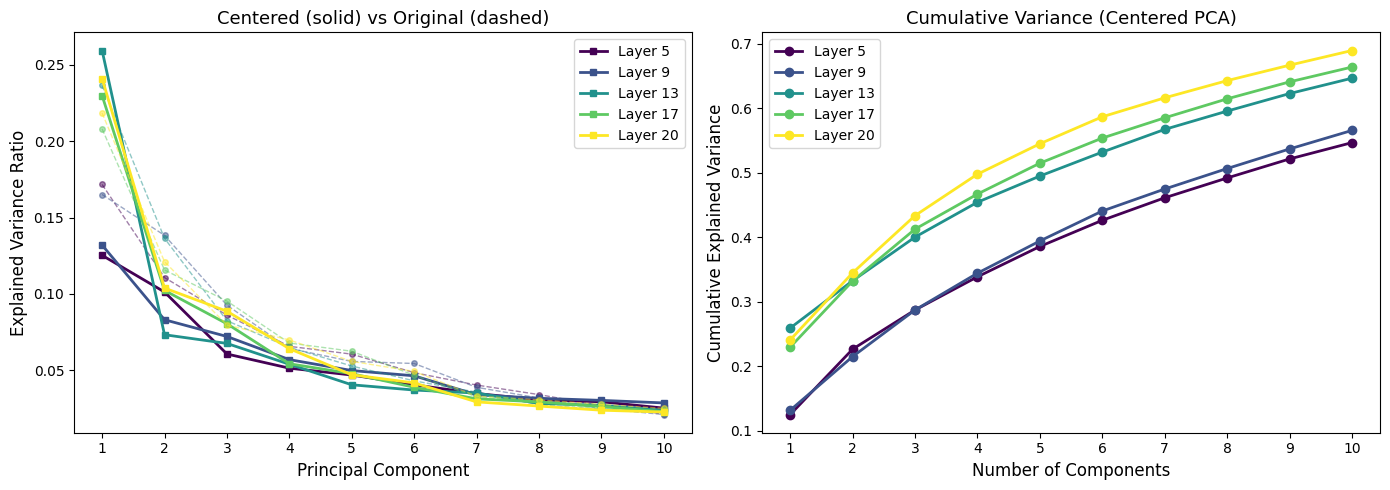


Centered PC1 Poles Across Layers

Layer 5 (PC1 = 12.5%):
  + pole: healthcare practitioner, agnostic person, gun owner, Millennial, high school graduate
  - pole: person of other religion, person of different race than , person who does not own a gun, person who has never been marr, person who believes in a highe

Layer 9 (PC1 = 13.2%):
  + pole: person with a neutral politica, agnostic person, White person, middle class person, person who finds life exciting
  - pole: person with less than high sch, person with an extremely conse, person in poor health, person who finds life dull, unhappy person

Layer 13 (PC1 = 25.9%):
  + pole: person with a neutral politica, Other, fairly happy person, person who finds life exciting, middle class person
  - pole: unhappy person, person in poor health, person who finds life dull, person with less than high sch, person with an extremely conse

Layer 17 (PC1 = 23.0%):
  + pole: person with a neutral politica, fairly happy person, person who finds lif

In [17]:
# Plot: explained variance comparison across layers (original vs centered)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PC1-PC10: original (dashed) vs centered (solid)
ax = axes[0]
colors_layer = plt.cm.viridis(np.linspace(0, 1, len(comparison_layers)))
for i, layer in enumerate(comparison_layers):
    ev_o = layer_results_orig[layer]['explained_variance'][:10]
    ev_c = layer_results_centered[layer]['explained_variance'][:10]
    ax.plot(range(1, 11), ev_o, 'o--', color=colors_layer[i], alpha=0.5, linewidth=1, markersize=4)
    ax.plot(range(1, 11), ev_c, 's-', color=colors_layer[i], label=f'Layer {layer}', linewidth=2, markersize=5)
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Explained Variance Ratio', fontsize=12)
ax.set_title('Centered (solid) vs Original (dashed)', fontsize=13)
ax.legend()
ax.set_xticks(range(1, 11))

# Cumulative centered
ax = axes[1]
for i, layer in enumerate(comparison_layers):
    ev_c = layer_results_centered[layer]['explained_variance'][:10]
    ax.plot(range(1, 11), np.cumsum(ev_c), 'o-', color=colors_layer[i],
            label=f'Layer {layer}', linewidth=2, markersize=6)
ax.set_xlabel('Number of Components', fontsize=12)
ax.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax.set_title('Cumulative Variance (Centered PCA)', fontsize=13)
ax.legend()
ax.set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

# Compare PC1 poles across layers (centered)
print("\nCentered PC1 Poles Across Layers")
print("=" * 80)

for layer in comparison_layers:
    r = layer_results_centered[layer]
    projections = r['X_pca'][:, 0]
    sorted_idx = np.argsort(projections)

    top5 = [r['labels'][i].split('_', 1)[1][:30] for i in sorted_idx[-5:][::-1]]
    bot5 = [r['labels'][i].split('_', 1)[1][:30] for i in sorted_idx[:5]]

    print(f"\nLayer {layer} (PC1 = {r['explained_variance'][0]:.1%}):")
    print(f"  + pole: {', '.join(top5)}")
    print(f"  - pole: {', '.join(bot5)}")

## Summary & Interpretation

### Motivation
Phase 5 PCA on the original "X vs. generic" vectors was dominated by a shared baseline
(mean cosine similarity ~0.39 across all pairs). PC1 (23.6%) captured "attitudinal specificity"
rather than the expected liberal-conservative axis, and GSS phi-coefficient validation showed
near-zero correlation (r~0.04).

### Approach 2: Within-Category Centering
- Subtracts the category mean from each vector, removing within-category shared variance
- Preserves the 120-vector structure, so direct comparison with original PCA is possible
- GSS validation uses cosine similarity on centered vectors

### Approach 3: Explicit Contrastive Pairs
- Computes all C(n,2) pairwise differences within each category (~317 vectors)
- Each contrastive vector directly encodes "A vs B" with no shared baseline
- Produces a larger matrix but with purely oppositional information

### Key Questions
1. Does PC1 now separate liberal from conservative after removing the shared baseline?
2. Does GSS phi-coefficient validation improve from the r~0.04 baseline?
3. Are the PC poles more stable across layers after centering?
4. Which approach (centering vs contrastive) provides cleaner demographic axes?

### Next Steps
- **Phase 6**: LLM judge filtering for cleaner vector estimates
- **Phase 7**: Multi-turn demographic drift tracking
- **Phase 8**: Activation capping along demographic axes